# Лабораторная работа №3. Линейные модели для классификации

В задачах классификации, в отличие от задач регрессии, требуется по образу объекта определить его принадлежность к тому или иному классу.
В данной работе будет рассмотрена только задача бинарной (двухклассовой) классификации.
В качестве ответа классификатора используется
$$
P(C_1 | \mathbf\phi) = \sigma( \mathbf{w}^T \mathbf\phi),
$$
где
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
 
В случае логистической регрессии минимизируется функция штрафа
$$
E(\mathbf{w}) = -\sum_{n=1}^N\left( t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right).
$$

Её градиент равен
$$
\nabla E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \mathbf\phi(\mathbf{x}_n) =
\sum_{n=1}^N \left( \sigma(\mathbf{w}^T\mathbf\phi_n - t_n \right) \mathbf\phi_n = \mathbf\Phi^T (\mathbf{y} - \mathbf{T}),
$$
где $\mathbf{y} = (y_1, \dots, y_N)^T$ $-$ отклики распознавателя, $\mathbf{T} = (t_1, \dots, t_N)^T$ $-$ метки классов.
 
Выпишем классический метод градиентного спуска в матричной форме:
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \alpha\nabla E,\;\;\; i = 1, 2, \dots,
$$
где $\mathbf{w}_0$ задано, а $\nabla E = \nabla E(\mathbf{w}_i, T)$.
Заметим, что здесь $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$.
То есть в итерационной процедуре на каждой итерации для расчета $\nabla{E}$ используются вся выборка целиком.

Будем теперь вместо полной выборки $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$ на каждой итерации случайно выбирать $K$ элементов из T:
$T_i = \left( (\mathbf{x}_{i_1}, t_{i_1}), (\mathbf{x}_{i_2}, t_{i_2}), \dots, (\mathbf{x}_{i_K}, t_{i_K}) \right)$.
Назовем $T_i$ пакетом или пачкой (batch).
Индекс $i$ отражает то, что пакет векторов из обучающей выборки выбирается отдельно на каждой итерации.

При $K = 1$ получаем так называемый _стохастический градиентный спуск_ (stochastic gradient descent, SGD).

При $K = N$ используется вся выборка, получаем _классический метод градиентного спуска_ (vanilla gradient descent).

В остальных случаях ($1 < K < N$) метод называют _mini-batch gradient descent_.

На практике обычно _mini-batch gradient descent_ сходится быстрее, чем _vanilla gradient descent_.

Вместе со стохастическим градиентным спуском часто применяют момент.
Момент не позволяет резко измениться направлению спуска.
Это позволяет достичь более плавного и быстрого спуска.
В ряде случаев использование момента также позволяет не «свалиться» в локальный минимум.

**Momentum**.
Итерационный поиск осуществляется по следующему алгоритму:
$$
\begin{gather}
    \mathbf{w}_{i+1} = \mathbf{w}_i + \mathbf{v}_i,\;\;\; i = 1, 2, \dots, \\
    \mathbf{v}_i = \gamma \mathbf{v}_{i-1} - \alpha \nabla{E} \left( \mathbf{w}_i, (\mathbf{x}_{k_i}, t_{k_i} \right), \\
    \mathbf{v}_0 = 0.
\end{gather}
$$

Для параметра $\gamma$ обычно выбирается значение 0.9 или близкое к этому.

In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection, metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import timeit

mpl.rcParams['axes.grid'] = True

## Задание №1

Разделите выборку на обучающую и тестовую.
Размер тестовой выборки - 20% от размера исходной выборки.
Параметр `n_features` определяется как `3 + mod(<порядковый номер в списке>, 3)`, `n_samples` необходимо взять `600 - 100 * mod(<порядковый номер в списке>, 3)`.
В случае возникновения ошибки, измените параметр `n_informative`.

In [2]:
# При значении n_features = 3 + mod(3, 3) = 3 нельзя удовлетворить условие
# n_informative + n_redundant + n_repeated > n_features, меняя только n_informative,
# поэтому я взял значение n_features = 4.
x, y = sk.datasets.make_classification(n_samples=600, n_features=4, random_state=145)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2)
print(x_train.shape, y_train.shape)

(480, 4) (480,)


## Задание №2

Реализуйте алгоритм _mini-batch gradient descent_.
В качестве критерия выхода возьмите ограничение по количеству эпох.
Для повторяемости результатов и корректного сравнения алгоритмов, везде используйте одинаковый генераторатор псевдослучайных чисел.

In [3]:
class GradientDescent:
    def __init__(self, batch_size, alpha=1e-3, eps=1e-6, epoch=100):
        self.rng = np.random.default_rng(seed=489)
        self.alpha, self.eps, self.epoch, self.batch_size = alpha, eps, epoch, batch_size
    
    def fit(self, x, y, val_x, val_y):
        x = np.asmatrix(x)
        y = np.asmatrix(y).T
        
        self.w = np.asmatrix(self.rng.uniform(-1, 1, size=x.shape[1]+1)).T
        self.loss, self.precision = [], []
        self.val_loss, self.val_precision = [], []

        xx = self._extend(x)
        idxs = range(0, xx.shape[0], self.batch_size)
        for i in range(self.epoch):
            batches = tuple(zip(xx, y))
            for idx in self.rng.permutation(idxs):
                xb, yb = batches[idx]
                deriv = self._grad(self.w, xb, yb)
                self._update(xx[:, 1:], deriv)

            self.loss.append(sk.metrics.log_loss(y.A1, (xx @ self.w).A1))
            self.precision.append(sk.metrics.average_precision_score(y.A1, (xx @ self.w).A1))
            self.val_loss.append(sk.metrics.log_loss(val_y, (self._extend(val_x) @ self.w).A1))
            self.val_precision.append(sk.metrics.average_precision_score(val_y, (self._extend(val_x) @ self.w).A1))

    def _grad(self, w, x, y):
        return x.T @ (x @ w - y)
        
    def _extend(self, x):
        ones = np.asmatrix(np.repeat(1, x.shape[0])).T
        return np.concatenate((ones, x), axis=1)

    def _update(self, x, derr):
        self.w -= self.alpha * derr

    def predict_proba(self, x):
        xx = self._extend(x)
        return (xx @ self.w).reshape(-1)

    def __call__(self, x):
        return self.predict_proba(x).round().astype(np.int8).clip(0, 1).A1

# Тестирование
test_x = np.array([[1, 1, 1], [2, 4, 16], [3, 9, 27]])
gd = GradientDescent(batch_size=1)
gd.fit(test_x, [1, 0, 1], val_x=test_x, val_y=[1, 0, 1])
print(f"Response {(probe := gd(test_x))}")
assert sk.metrics.precision_score(probe, [1, 0, 1]) == 1.0, 'Метод недостаточно точный'
assert sk.metrics.accuracy_score(probe, [1, 0, 1]) > 0.6, 'Метод недостаточно точный'

Response [1 0 1]


## Задание №3

Протестируйте написанный алгоритм, подберите параметры градиентного спуска, дающие после обучения классификатор с наилучшей точностью
($\text{точность} = \frac{\text{количество правильно классифицированных векторов}}{\text{количество векторов}}$).
Сравните классический градиентный спуск, стохастический и mini-batch.
Для начала возьмите следующие параметры:

* случайные начальные значения весов (равномерное распределение на отрезке $[-1; 1]$ для каждой компоненты);
* размер шага обучения $\alpha = 10^{-5}$;
* размер пакета _batch size_ = 20;
* максимальное количество эпох 1000;
* начальные веса должны совпадать.

Приведите в отчет полученную точность и значение функции штрафа на тестовой и обучающей выборках.
Постройте графики для каждого тестируемого размера батча:

* зависимость функции штрафа на обучающей и тестовой выборках от номера эпохи;
* зависимость точности на обучающей и тестовой выборках от номера эпохи;
* зависимость времени выполнения алгоритма от размера батча.

Batch size = 1, precision = 0.8707664884135473
Batch size = 20, precision = 0.8487858032378581
Batch size = 50, precision = 0.8163875598086124
Batch size = 100, precision = 0.8707664884135473
Batch size = 480, precision = 0.5224386724386725
CPU times: user 10.1 s, sys: 6.46 ms, total: 10.1 s
Wall time: 10.2 s


Text(0.5, 1.0, 'Зависимость времени работы от размера батча')

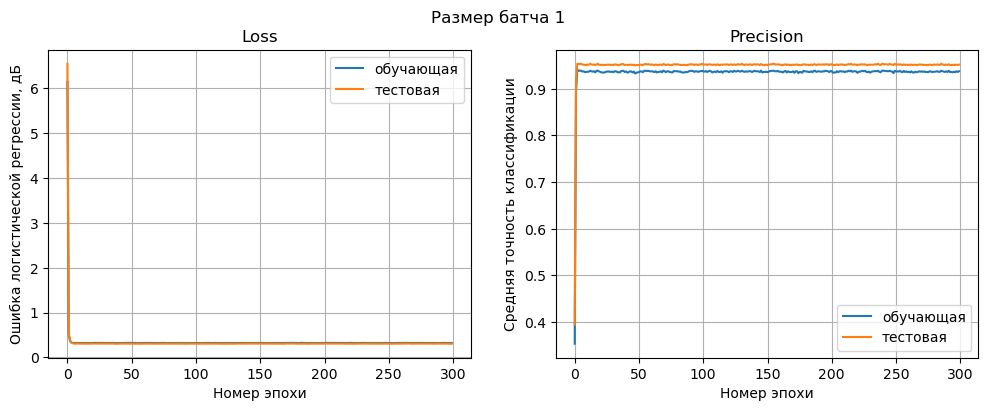

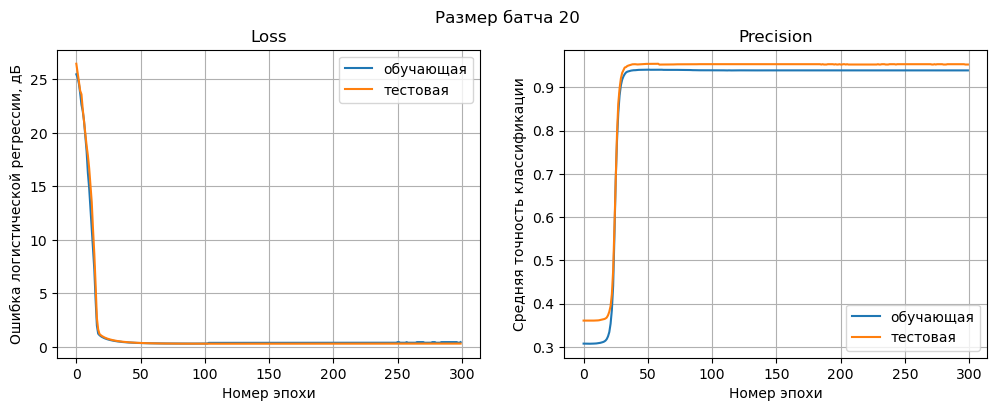

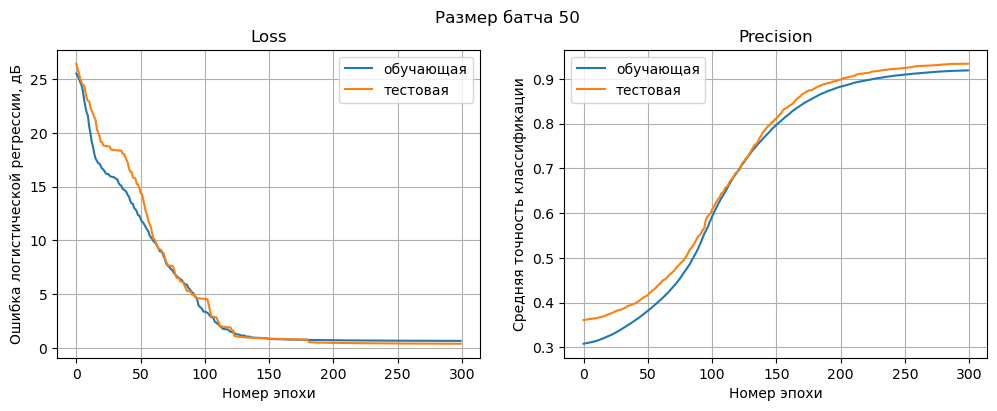

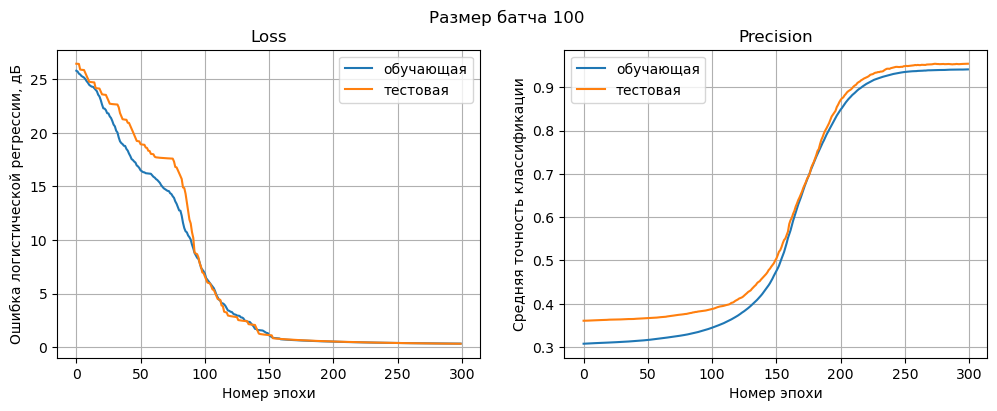

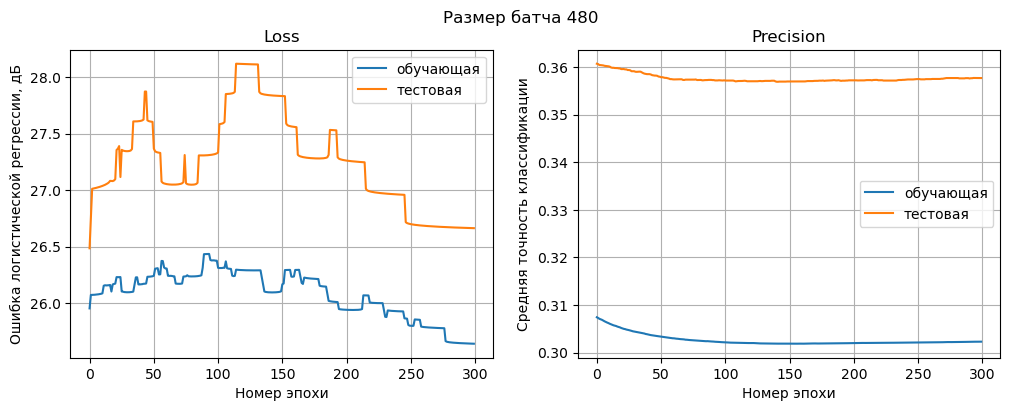

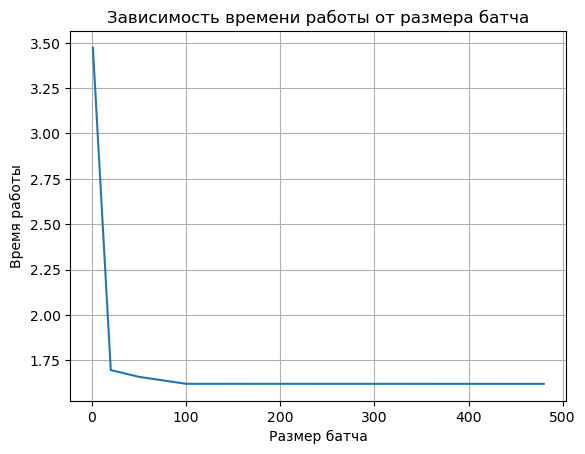

In [4]:
%%time

times = {}
for batch in [1, 20, 50, 100, x_train.shape[0]]:
    gd = GradientDescent(batch, epoch=300, alpha=1e-3)
    t = timeit.default_timer()
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    times[batch] = timeit.default_timer() - t
    y_pred = gd(x_test)
    print(f"Batch size = {batch}, precision = {sk.metrics.average_precision_score(y_test, y_pred)}")
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая')
    ax0.set(xlabel='Номер эпохи', ylabel='Ошибка логистической регрессии, дБ', title='Loss')
    ax0.legend()
    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая')
    ax1.set(xlabel='Номер эпохи', ylabel='Средняя точность классификации', title='Precision')
    ax1.legend()
    fig.suptitle(f"Размер батча {batch}")
    
plt.figure()
plt.plot(times.keys(), times.values())
plt.xlabel('Размер батча')
plt.ylabel('Время работы')
plt.title('Зависимость времени работы от размера батча')

**Вопросы**

1. Зависит ли точность от размера батча? Почему?
1. Зависит ли время работы алгоритма от размера батча? Почему?

**Ответы**

1. Да, зависит, потому что размер батчей влияет на количество батчей, и в конечном итоге на чувствительность к начальным весам.
1. Да, зависит, потому что общее число итераций завис ит от количества эпох и количества пакетов, а количество пакетов зависит от размера пакета.

Дополнение. Наилучший результат достигается при использовании пакетов размером 50, т.к. при той же точности, что и у стохастического градиентного спуска, время исполнения меньше в несколько раз.

## Задание №4

Реализуйте метод оптимизации градиентного спуска _momentum_.
Примените наследование от `GradientDescent` и перегрузите метод `_update`, в котором происходят обновления весов модели.

In [5]:
class MomentumGD(GradientDescent):
    def __init__(self, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma = gamma
        
    def fit(self, x, *args, **kwargs):
        self.v = np.zeros((x.shape[1] + 1, 1))
        super().fit(x, *args, **kwargs)
    
    def _update(self, x, err):
        self.v = self.gamma * self.v - self.alpha * self.w
        self.w += self.v

## Задание №5

Подберите параметры, дающие улучшение сходимости (в большей степени это относится к параметру $\gamma$).  

* Сравните скорость сходимости со скоростью в задании 2.
Для этого постройте графики, на которых сравниваются скорости сходимости и качества модели для **обучающей** выборки.
* Сравните достигнутую точность с точностью в задании 2.
Удалось ли лучше обучить модель?
Чтобы эксперимент был «честным» следует запускать все методы с одними и теми же параметрами и с одними и теми же начальными значениями весов.

Gamma = 0.1, precision = 0.55
Gamma = 0.3, precision = 0.55
Gamma = 0.6, precision = 0.55
Gamma = 0.9, precision = 0.55
Gamma = 1.0, precision = 0.55
CPU times: user 9.86 s, sys: 6.5 ms, total: 9.87 s
Wall time: 9.92 s


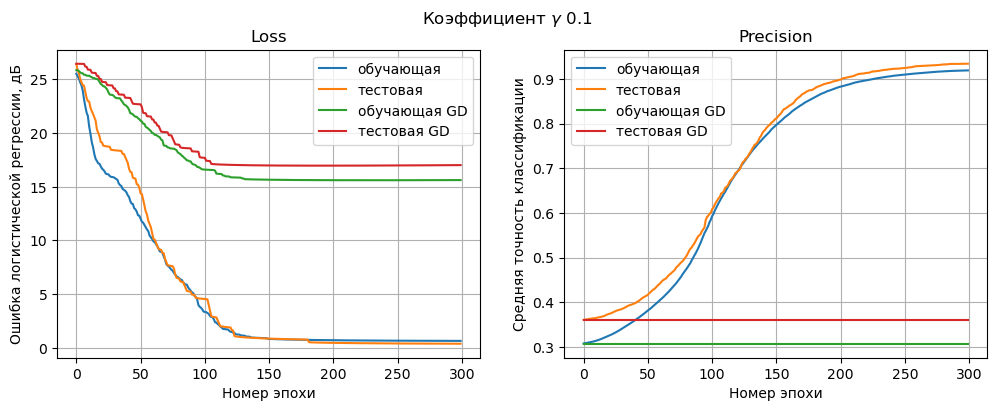

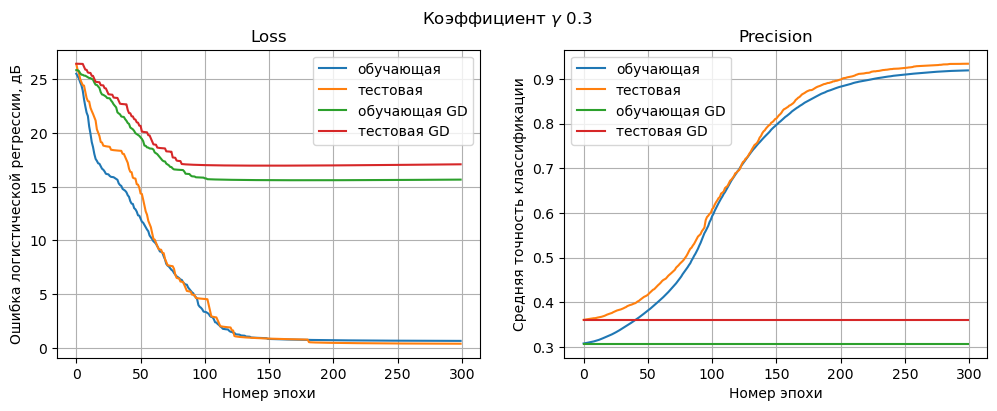

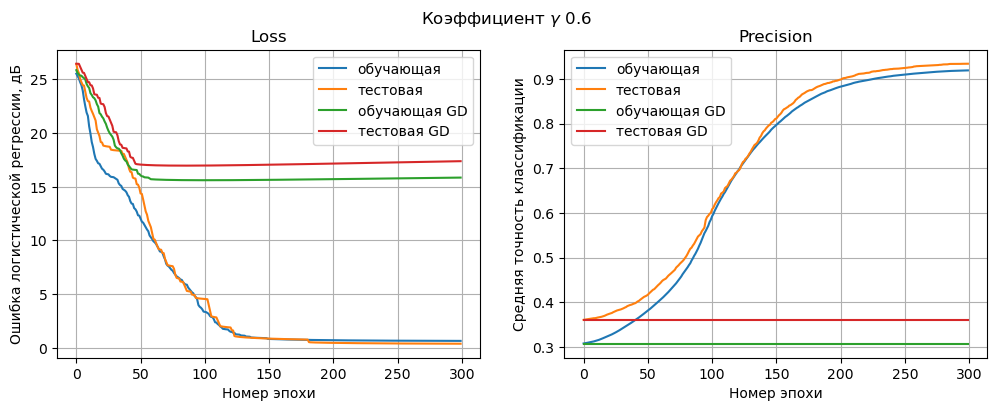

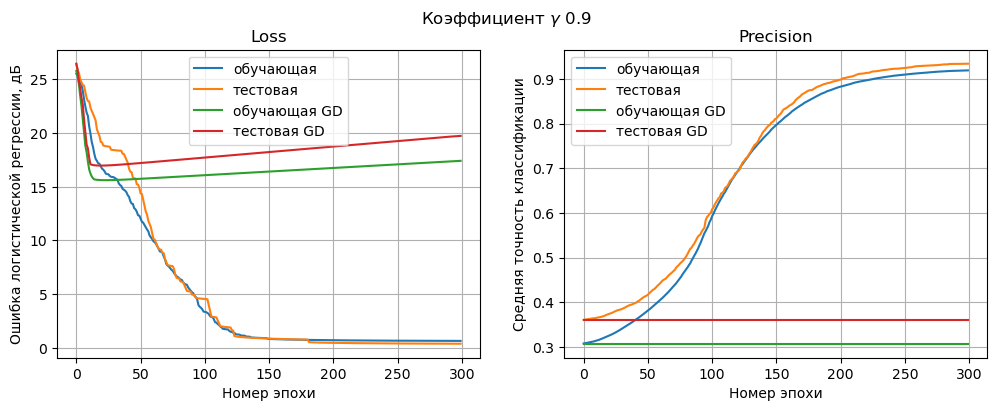

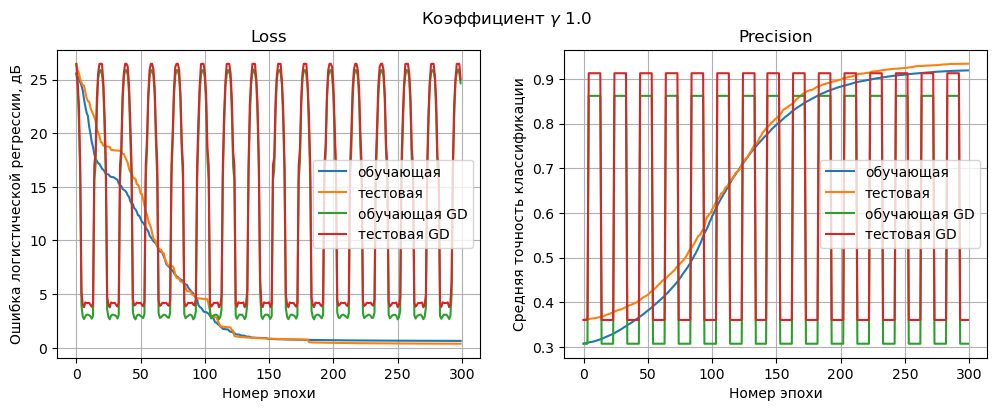

In [6]:
%%time

gd0 = GradientDescent(batch_size=50, epoch=300, alpha=1e-3)
gd0.fit(x_train, y_train, val_x=x_test, val_y=y_test)

for gamma in [0.1, 0.3, 0.6, 0.9, 1.0]:
    gd = MomentumGD(gamma=gamma, batch_size=50, epoch=300, alpha=1e-3)
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    y_pred = gd(x_test)
    print(f"Gamma = {gamma}, precision = {sk.metrics.average_precision_score(y_test, y_pred)}")
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    ax0.plot(range(len(gd0.loss)), gd0.loss, label='обучающая')
    ax0.plot(range(len(gd0.val_loss)), gd0.val_loss, label='тестовая')
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая GD')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая GD')
    ax0.set(xlabel='Номер эпохи', ylabel='Ошибка логистической регрессии, дБ', title='Loss')
    ax0.legend()
    ax1.plot(range(len(gd0.precision)), gd0.precision, label='обучающая')
    ax1.plot(range(len(gd0.val_precision)), gd0.val_precision, label='тестовая')
    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая GD')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая GD')
    ax1.set(xlabel='Номер эпохи', ylabel='Средняя точность классификации', title='Precision')
    ax1.legend()
    fig.suptitle(f"Коэффициент $\gamma$ {gamma}")

**Вопросы**

1. Какой из алгоритмов быстрее достигает итоговой точности?
1. С ростом коэффициента $\gamma$ алгоритм сходится быстрее или медленее?
1. Что происходит при очень большом коэффициенте $\gamma$?

**Ответы**

1. Более быстрой является модификация алгоритма градиентного спуска, использующая момент. 
1. С ростом коэффициента $\gamma$ алгоритм сходится быстрее до определённого момента, после чего расходится.
1. При большом значении коэффициента $\gamma$ алгоритм расходится.

Дополнение. Не очень понятно, почему точность (precision) ведёт себя так странно в случае модификации, использующей момент. Если я правильно понимаю, то такое значение точности означает не очень качественную классификацию. Скорее всего это связано с плохой разделимостью классов, как я понял из заданий ниже.

## Задание №6

Для какой-либо из обученных моделей постройте график, на котором изображено разделение пространства признаков на две области.
Проверьте, что разделяющая поверхность - линейная.

Text(0, 0.5, 'X1')

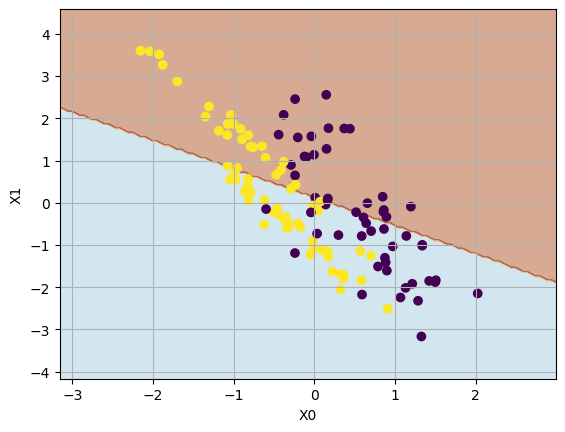

In [7]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = gd0(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.xlabel('X0')
plt.ylabel('X1')

## Задание №7

Классы в выборке не являются линейно разделимыми.
С данной проблемой можно бороться, воздействуя какой-то функцией на старые признаки:
$$
\mathbf{\phi}(\mathbf{x}) = \left( \phi_1(x_1, \dots, x_n), \dots, \phi_n(x_1, \dots, x_n) \right)^T.
$$

Покажите, как изменяется разделяющая поверхность, если задавать разную функцию отображения.
Постройте график, на котором изображено разделение пространства признаков и приведите величину достигнутой точности на тестовой выборке.
Попробуйте добиться лучшей точности (необязательно).

Score = 0.7153288201160541
CPU times: user 1.78 s, sys: 2.29 ms, total: 1.79 s
Wall time: 1.79 s


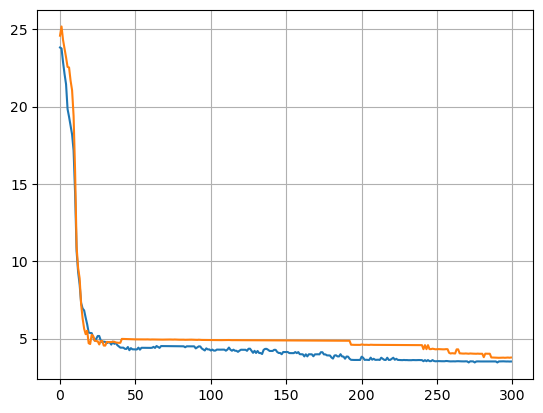

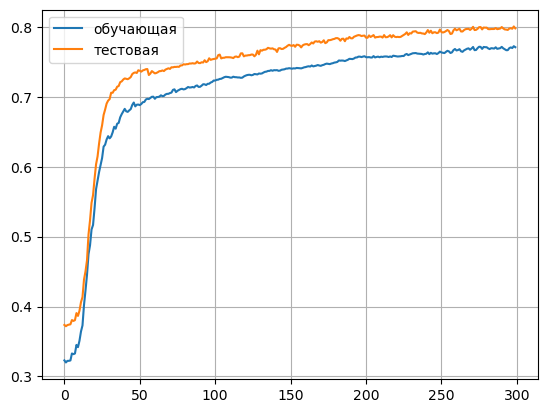

In [8]:
%%time

class MGD(GradientDescent):
    def _func(self, x):
        return x ** 3 + x ** 2 + x
    
    def fit(self, x, y, val_x, val_y):
        super().fit(self._func(x), y, self._func(val_x), val_y)
    
    def __call__(self, x):
        return super().__call__(self._func(x))

gdx = MGD(batch_size=50, epoch=300, alpha=1e-3)
gdx.fit(x_train, y_train, x_test, y_test)

plt.figure()
plt.plot(range(len(gdx.loss)), gdx.loss, label='обучающая')
plt.plot(range(len(gdx.val_loss)), gdx.val_loss, label='тестовая')

plt.figure()
plt.plot(range(len(gdx.precision)), gdx.precision, label='обучающая')
plt.plot(range(len(gdx.val_precision)), gdx.val_precision, label='тестовая')
plt.legend()

# plt.figure()
# Z = gdx(???)
# ???

print("Score =", sk.metrics.average_precision_score(y_test, gdx(x_test)))

**Выводы**:

Использование полиномиальной функции позволило ускорить сходимость метода, но точность не выросла.